<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/main/models/2DModels/2DCnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")
import zipfile


Mounted at /content/drive


In [2]:
!pip install -q mlflow
!databricks configure --host https://community.cloud.databricks.com/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
Username: gfesta24@gmail.com
Password: 
Repeat for confirmation: 


In [3]:
zip_ref = zipfile.ZipFile('drive/Shareddrives/Datasets SEFAI/fer2013.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import ParameterGrid
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Dataset Loading**

Did not use std normalization in the end, since results are slightly better without it (data are still normalized in the [0-1] interval).

In [5]:
def mean_std_calc(loader):
  cnt = 0
  fst_moment = torch.empty(3)
  snd_moment = torch.empty(3)

  for images, _ in loader:
      b, c, h, w = images.shape
      nb_pixels = b * h * w
      sum_ = torch.sum(images, dim=[0, 2, 3])
      sum_of_square = torch.sum(images ** 2,
                                dim=[0, 2, 3])
      fst_moment = (cnt * fst_moment + sum_) / (
                    cnt + nb_pixels)
      snd_moment = (cnt * snd_moment + sum_of_square) / (
                          cnt + nb_pixels)
      cnt += nb_pixels

  mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
  return mean, std

In [6]:
train_dir = "train" # Directory containing the training data
test_dir = "test"  # Directory containing the validation data

# Define the transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# **Rete convolutiva**

In [7]:
def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, 1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;


In [8]:

class CNN(nn.Module):
    def __init__(self):

        super(CNN, self).__init__()


        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 6 * 6, 256)

        self.bn7 = nn.BatchNorm1d(256)
        self.relu7 = nn.ReLU()

        self.dropout4 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.pool1(x)

        x = self.dropout1(x)
        #print("dropout1 ", x.shape)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        #print("conv4 ", x.shape)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.pool2(x)

        x = self.dropout2(x)


        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        #print("conv6 ", x.shape)
        x = self.bn6(x)
        x = self.relu6(x)

        x = self.pool3(x)
        x = self.dropout3(x)
        #print("dropout3 ", x.shape)
        x = x.view(-1, 256 * 6 * 6)
        #print(x.shape)
        x = self.fc1(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x



In [9]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/gfesta24@gmail.com/2DCnn")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1645340172644810', creation_time=1687361115096, experiment_id='1645340172644810', last_update_time=1688034311031, lifecycle_stage='active', name='/Users/gfesta24@gmail.com/2DCnn', tags={'mlflow.experiment.sourceName': '/Users/gfesta24@gmail.com/2DCnn',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'gfesta24@gmail.com',
 'mlflow.ownerId': '1923923806180228'}>

In [ ]:
param_grid = {'batch_size': [64, 128, 256, 512],'lr': [0.0001, 0.001], "decay":[0, 0.001, 0.01]}
expanded_grid = ParameterGrid(param_grid)
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("/Users/gfesta24@gmail.com/2DCnn")

for i in range(len(expanded_grid)):

  runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], filter_string=" and ".join([f"params.{k} = '{v}'" for k, v in expanded_grid[i].items()]))
  if not len(runs) == 0:
    print("RUN: ", [f"params.{k} = '{v}'" for k, v in expanded_grid[i].items()], " già completata" )
  else:
    train_loader = DataLoader(train_dataset, batch_size=expanded_grid[i]['batch_size'], shuffle=True)

    test_loader = DataLoader(test_dataset, batch_size=expanded_grid[i]['batch_size'], shuffle=False)

    model = CNN()
    optimizer = optim.Adam(model.parameters(), lr=expanded_grid[i]['lr'], weight_decay=expanded_grid[i]['decay'])
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    mlflow.start_run()

    mlflow.set_tag("model_name", "2DCnn")
    mlflow.log_param("lr", expanded_grid[i]['lr'])
    mlflow.log_param("batch_size", expanded_grid[i]['batch_size'])
    mlflow.log_param("decay", expanded_grid[i]['decay'])

    acc_list_train=[]
    acc_list_test=[]
    num_epochs = 100
    best_loss = 1000
    patience=3
    counter = 0
    stop = False

    # Training loop
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(counter)
        if stop:
          print(stop)
          break
        model.train()
        running_loss = 0.0
        total_correct = 0
        seen = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, acc = accuracy(outputs, labels)
            total_correct += acc
            seen +=labels.shape[0]
            running_loss += loss.item()

        train_accuracy = total_correct / seen
        train_loss = running_loss / len(train_loader)
        print (f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {total_correct/seen:.4f}')
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_accuracy, step=epoch)
        model.eval()

        total_correct = 0
        seen = 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, acc = accuracy(outputs, labels)
                total_correct += acc
                seen +=labels.shape[0]

        test_accuracy = total_correct / seen
        test_loss = running_loss / len(test_loader)
        print("Test acc: ", test_accuracy)
        print("Test loss: ", test_loss)
        mlflow.log_metric("test_acc", test_accuracy, step=epoch)
        mlflow.log_metric("test_loss", test_loss, step=epoch)

        if test_loss < best_loss:
              print("MIGLIORATO")
              torch.save(model.state_dict(), 'model_weights.pth')
              best_loss = test_loss
              best_model_train_acc=train_accuracy
              best_model_test_acc=test_accuracy
              best_model_test_loss=test_loss
              best_model_train_loss=running_loss / len(train_loader)
              counter = 0
              # Salva i pesi del modello se la validation loss è migliorata
              torch.save(model.state_dict(), 'best_model.pt')
        else:
            counter += 1
            # Verifica se raggiunto il criterio di early stopping
            if counter >= patience:
                  print(f'Early stopping at epoch {epoch+1}')
                  mlflow.set_tag("Epochs_stopped", epoch+1)
                  mlflow.log_artifact("best_model.pt")
                  mlflow.log_metric("best_test_acc", best_model_test_acc)
                  mlflow.log_metric("best_test_loss", best_model_test_loss)
                  mlflow.log_metric("best_train_acc", best_model_train_acc)
                  mlflow.log_metric("best_train_loss", best_model_train_loss)
                  mlflow.end_run()
                  stop=True
        print("BEST TEST LOSS: ", best_loss)

        print(f"Epoch {epoch+1}/{50}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


RUN:  ["params.lr = '0.0001'", "params.decay = '0'", "params.batch_size = '64'"]  già completata
RUN:  ["params.lr = '0.001'", "params.decay = '0'", "params.batch_size = '64'"]  già completata
RUN:  ["params.lr = '0.0001'", "params.decay = '0.001'", "params.batch_size = '64'"]  già completata
RUN:  ["params.lr = '0.001'", "params.decay = '0.001'", "params.batch_size = '64'"]  già completata
RUN:  ["params.lr = '0.0001'", "params.decay = '0.01'", "params.batch_size = '64'"]  già completata
RUN:  ["params.lr = '0.001'", "params.decay = '0.01'", "params.batch_size = '64'"]  già completata
RUN:  ["params.lr = '0.0001'", "params.decay = '0'", "params.batch_size = '128'"]  già completata
RUN:  ["params.lr = '0.001'", "params.decay = '0'", "params.batch_size = '128'"]  già completata
RUN:  ["params.lr = '0.0001'", "params.decay = '0.001'", "params.batch_size = '128'"]  già completata
RUN:  ["params.lr = '0.001'", "params.decay = '0.001'", "params.batch_size = '128'"]  già completata
RUN:  ["p

In [10]:
def get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_id]).sort_values(f"{metric_name}")
    lowest_metric_run = runs.iloc[0]

    run_id = lowest_metric_run.run_id
    artifact_uri = mlflow.get_artifact_uri(run_id)

    artifact_path = f"{artifact_uri}/{artifact_name}"
    return run_id, artifact_path

# Specifica l'ID del tuo esperimento e i nomi delle metrica e dell'artefatto
experiment_id = '1645340172644810'
metric_name = 'metrics.best_test_loss'
artifact_name = 'model_weights'

run_id, artifact_path = get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name)

print("Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:")
print(artifact_path)

Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:
dbfs:/databricks/mlflow-tracking/1645340172644810/2fc2ab6039694f7cb5ab29a94d9ddcc4/artifacts/f0f2e1726bda453784d5cb43c03e91ee/model_weights


In [11]:
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path="/content/artefatto")

'/content/artefatto/'

Test Metrics:
Accuracy: 0.6241292839230984
Precision: [0.49522984 0.6557377  0.57800512 0.86460808 0.5465798  0.47486413
 0.73582766]
F1 Score: [0.54097584 0.46511628 0.31943463 0.84210526 0.60621387 0.51415962
 0.75773497]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.54       958
           1       0.66      0.36      0.47       111
           2       0.58      0.22      0.32      1024
           3       0.86      0.82      0.84      1774
           4       0.55      0.68      0.61      1233
           5       0.47      0.56      0.51      1247
           6       0.74      0.78      0.76       831

    accuracy                           0.62      7178
   macro avg       0.62      0.57      0.58      7178
weighted avg       0.63      0.62      0.61      7178



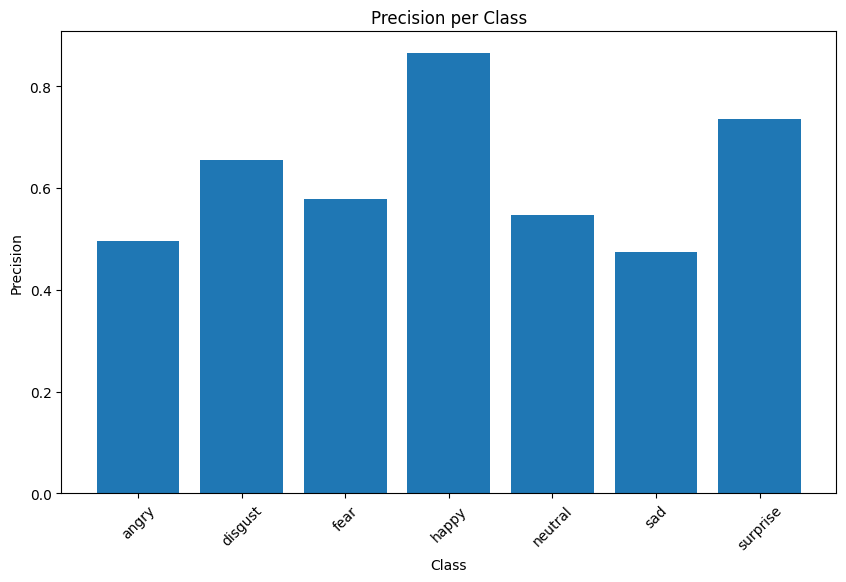

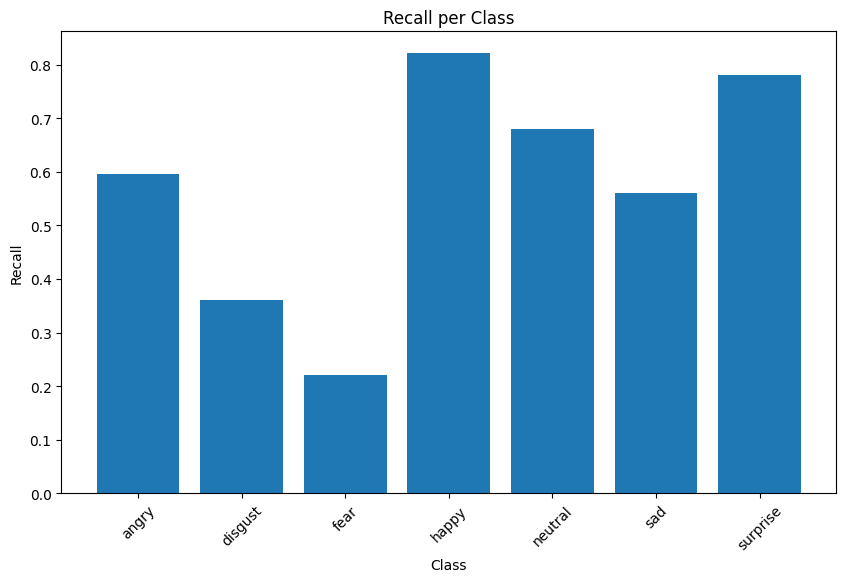

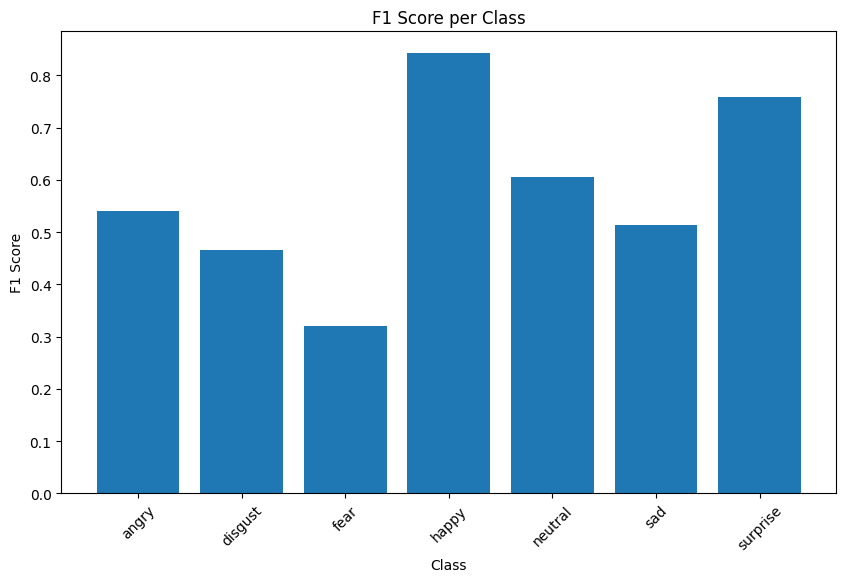

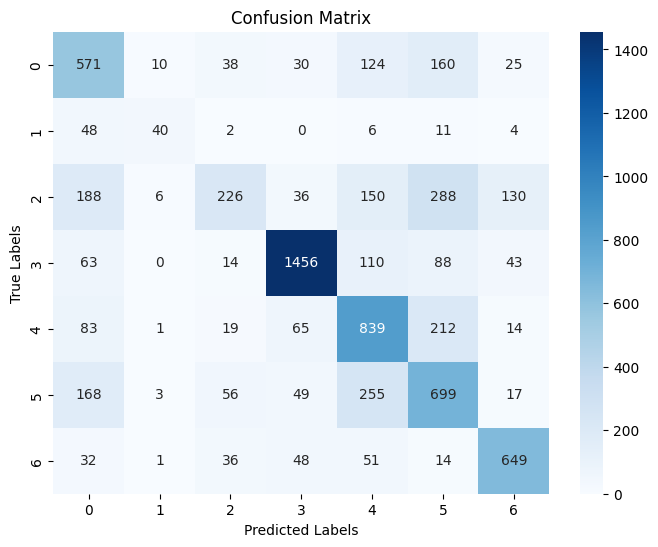

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = CNN()
model.load_state_dict(torch.load("/content/artefatto/best_model.pt"))
model.eval()
model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)

# Lista delle etichette delle classi
#class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
class_labels=[9,9,9,9,9,9,9]
for label in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
  class_labels[train_dataset.class_to_idx[label]]=label




# Crea il grafico a barre per la precisione
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision)
plt.title('Precision per Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per il recall
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall)
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per l'F1-score
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()


# Calcola la matrice di confusione
cm = confusion_matrix(test_labels, test_predictions)

# Crea una figura e un'asse per la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Imposta i nomi delle etichette sulle assi x e y
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Visualizza la matrice di confusione
plt.show()

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=75aa00bcd401123e74b0e53d5a3fb72337774565aa13166b60f8b91d0e4f5d55
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


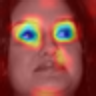

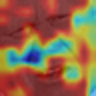

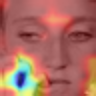

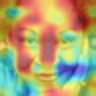

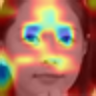

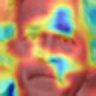

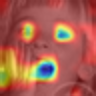

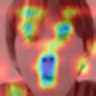

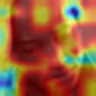

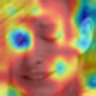

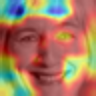

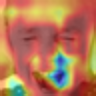

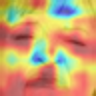

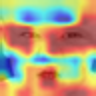

In [ ]:
!pip install pillow
import numpy as np
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from google.colab.patches import cv2_imshow
from skimage.transform import resize

target_layers = [model.conv6]

# Percorsi delle immagini di input
input_image_paths = [
    '/content/test/angry/PrivateTest_12766285.jpg',
    '/content/test/disgust/PrivateTest_34013087.jpg',
    '/content/test/fear/PrivateTest_11014592.jpg',
    '/content/test/happy/PrivateTest_1533232.jpg',
    '/content/test/neutral/PrivateTest_11724564.jpg',
    '/content/test/sad/PrivateTest_13437169.jpg',
    '/content/test/surprise/PrivateTest_14522193.jpg',
    '/content/test/surprise/PublicTest_10709121.jpg',
    '/content/test/sad/PrivateTest_77462938.jpg',
    '/content/test/neutral/PrivateTest_74313024.jpg',
    '/content/test/happy/PrivateTest_52544508.jpg',
    '/content/test/fear/PrivateTest_72173710.jpg',
    '/content/test/disgust/PublicTest_86861373.jpg',
    '/content/test/angry/PrivateTest_56252993.jpg'
]

# Creazione di una lista per contenere le immagini elaborate
visualizations = []

for input_image_path in input_image_paths:
    input_image = Image.open(input_image_path)
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    input_tensor = transform(input_image).unsqueeze(0)

    immagine = cv2.imread(input_image_path)
    input_image = immagine.astype(np.float32) / 255.0

    # Costruzione dell'oggetto CAM una volta sola e riutilizzo sulle immagini successive
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

    targets = [ClassifierOutputTarget(6)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

    # Upscaling dell'immagine
    upscaled_image = resize(visualization, (2 * input_image.shape[1], 2 * input_image.shape[0]), preserve_range=True)

    visualizations.append(upscaled_image)


    #visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)
    #visualizations.append(visualization)
    cv2_imshow(upscaled_image)
